# Welcome

## Homework #2. Practice

Author: [Nikita Balabin](mailto:nikita.balabin@skoltech.ru)

In this task, you are asked to be a bit bayesian (also, you can see: https://arxiv.org/abs/2002.10118). We consider the nice dataset: pictures with animal faces. It could be found and downloaded here: https://www.kaggle.com/andrewmvd/animal-faces and contain 3 classes of images: cat, dog and wild. The deep neural networks are known to be overconfient, so we make some attempts to mitigate this problem.

1. We start from the ordinary training of the NN.
2. Then we consider the Laplace approximation of the trained NN. The advantage of the such approach is that we did not change the training procedure.
3. Finaly, we consider the training with ELBO optimization in order to find the gaussian posterior.

<img src='img_for_task/intro.png'  width="40%" height="40%">

As the feature extractor $\phi(x)$ for this problem we will use ResNet18 ```torchvision.models.resnet18(pretrained=True)``` and train only the last FC layer.

#### Links of problems:
[Problem 1](#problem1) 10 points

[Problem 2](#problem2) 20points

[Problem 3](#problem3) 20 points 

------ Total : 50 points  -------

### Model

Consider dataset

$$
\begin{aligned}
& \{(x_n, y_n)\}_{n=1}^{N} \\
& x_n\in\mathbb{R}^{3\times D\times D} \text{ animal face images} \\
& y_n\in\{1,2,3\} \text{ labels}
\end{aligned}
$$

To model probability output we consider linear layer + soft-max on top of the feature extractor $\phi(x)$.

$$
\begin{aligned}
& p(y_n=i|x_n, W) = \text{Softmax}(W\phi(x), i)
\end{aligned}
$$



Also we put the prior distribution over the $W$, $\pi(W) = \mathcal{N}(\text{vec}(W)|\vec{0},A^{-1})$, where matrix $A$ is diagonal.

<a id='problem1'></a>
#### Problem 1 (10 points)
1. Fix $A$. You can think of it as a $l2$ regulariazation coefficient. Find MAP estimate of $W$, so that the accuracy of the model on the validation set is **more** than $95\%$.

2. Classify some out of the distriubtion pictures. For example, photos of cars or a cartoon character or something else that enjoy. Plot them with predicted class label and probability.  

3. Make the histogram of the top-class probability over the test set.

<a id='problem2'></a>
#### Problem 2, (20 points)
1. Consider the Laplace approximation of the posterior and approximation of the posterior-predictive distribution of the trained model. As Hessian consider two options:
    - full hessian
    - only diagonal part

2. Re-do point 2. and 3. from Problem 1 and compare results between full-Laplace, diagonal part-Laplace and just MAP.

<a id='problem3'></a>
#### Problem 3, (20 points)

$$
p(Y,W|X,A) = \left[\prod\limits_{n=1}^{N}p(y_n|x_n, W)\right]\mathcal{N}(\text{vec}(W)|\vec{0},A^{-1}).
$$

And we want to optimise ELBO with variational distribution $q$:

$$
\mathcal{L}[q, A] = \int q(W)\log\frac{p(y,W|x,A)}{q(W)}dW.
$$

Let's make the following assumptions:

$$
\begin{aligned}
& q(W) = \mathcal{N}(\text{vec}(W)|m,S) \\
\end{aligned}
$$
 
The plan for the solution is the following: 
 
  1. Derive the equation for $\mathcal{L}[m, S, A]$, take all expectations that can be taken analytically. Here, again consider two options:
      - Train diagonal $S$
      - Train full covariance matrix $S$
  2. From first order condition find optimal $\alpha^{i}$ (diagonal elements of $A$).
  3. Derive the equation for $\mathcal{L}[m, S]$ by pluging-in optimal $A$. 
 
Re-do point 2. and 3. from Problem 1 above and compare results.

#### Problem 1

In [1120]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, models, transforms

from PIL import Image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [1438]:
BATCH_SIZE = {"train": 32, "val": 1}

transform = transforms.Compose([transforms.ToTensor()])

data_dir = 'afhq/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE[x], shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [1439]:
A = 1 # A - constant diagonal
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.feature_extractor = models.resnet18(pretrained=True)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        for param in self.feature_extractor.fc.parameters():
            param.requires_grad = True
        self.linear = torch.nn.Linear(self.feature_extractor.fc.out_features, len(class_names), bias=False)
        torch.nn.init.normal_(self.linear.weight, mean=0.0, std=1/A)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.linear(x)
        return x

In [1440]:
model = Model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, weight_decay=A)

In [ ]:
from tqdm.auto import tqdm

EPOCHS = 5

for epoch in range(EPOCHS):
    print(f"epoch: {epoch+1}")
    model.train()
    for inputs, labels in tqdm(dataloaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    running_corrects = 0
    for inputs, labels in tqdm(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    val_acc = running_corrects.double() / dataset_sizes['val']
    print("Validation accuracy: {0:0.0f}%".format(100*val_acc))

In [1442]:
model.eval()
running_corrects = 0
for inputs, labels in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data)
val_acc = running_corrects.double() / dataset_sizes['val']
print("Validation accuracy: {0:0.0f}%".format(100*val_acc))


Validation accuracy: 96%


In [1443]:
import matplotlib.pyplot as plt

def plot_prediction(model, img_path):
    img = Image.open(img_path).resize((512,512)) 
    tensor_img = transform(img)
    with torch.no_grad():
        output = model(tensor_img.unsqueeze(0).to(device))
        probs = F.softmax(output, dim=1)
        _, preds = torch.max(probs, 1)
    print("{0}, {1:0.0f}%".format(class_names[preds[0].item()], 100*probs.max().item()))
    plt.imshow(img);

cat, 100%


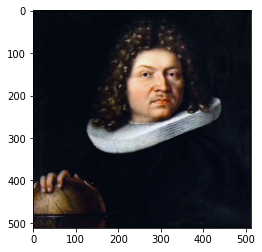

In [1444]:
plot_prediction(model, 'img_for_task/jacob-bernoulli_eI1JNJw.jpeg')

cat, 100%


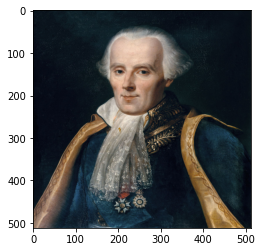

In [1445]:
plot_prediction(model, 'img_for_task/MAT.1re.11.SYNT.laplace-retouche.jpg')

cat, 100%


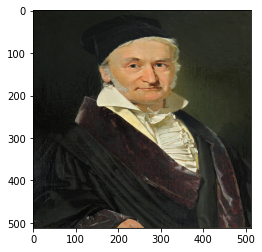

In [1446]:
plot_prediction(model, 'img_for_task/karl-gauss.jpeg')

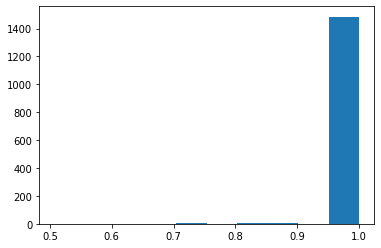

In [1447]:
import numpy as np
probs = np.array([])
for inputs, labels in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    optimizer.zero_grad()
    with torch.no_grad():
        outputs = model(inputs)
        output_probs = F.softmax(outputs, dim=1)
        probs = np.append(probs, output_probs.max(1).values.cpu().numpy())


# top-class probability
plt.hist(probs);

#### Problem 2

Sample W.

In [1449]:
W_map = model.linear.weight.clone().detach()
criterion = nn.CrossEntropyLoss(reduction='sum')

for inputs, labels in dataloaders['train']:
    inputs = inputs[0].to(device)
    labels = labels[0].to(device)
    break

optimizer.zero_grad()
outputs = model(inputs.unsqueeze(0))
loss = criterion(F.softmax(outputs, dim=1), labels.unsqueeze(0))

hess = torch.zeros((3000, 3000))

grad = torch.autograd.grad(outputs=loss, inputs=model.linear.weight, create_graph=True)
grad = grad[0].squeeze()

for i in tqdm(range(3000)):
    model.zero_grad()
    second_order_grad = torch.autograd.grad(outputs=grad[i//1000][i%1000], inputs=model.linear.weight, retain_graph=True)
    second_order_grad = second_order_grad[0].squeeze()
    hess[i, :] = second_order_grad.view(3000)

In [1450]:
from torch.distributions import MultivariateNormal

@torch.no_grad()
def predict(inputs, kind='full'):
    phi = model.feature_extractor(inputs)
    sigma = hess + torch.eye(3000)*A
    if kind == 'diag':
        q = MultivariateNormal(W_map.view(3000), precision_matrix=torch.diag(torch.diag(sigma)).to(device))
    else:
        q = MultivariateNormal(W_map.view(3000), precision_matrix=sigma.to(device))

    # MC-integral
    n_sample = 1000
    W = q.sample((n_sample,)).reshape(n_sample, 3, 1000)
    logits = (phi.unsqueeze(0) @ W.permute(0,2,1)).squeeze().mean(0)

    return torch.softmax(logits, 0)

In [1451]:
def plot_laplace_prediction(model, img_path):
    img = Image.open(img_path).resize((512,512)) 
    tensor_img = transform(img)
    for kind in ['full', 'diag']:
        output = predict(tensor_img.unsqueeze(0).to(device), kind)
        print("{0}: {1}, {2:0.0f}%".format(kind, class_names[torch.argmax(output).item()], 100*output.max().item()))
    plt.imshow(img);

full: cat, 100%
diag: cat, 100%


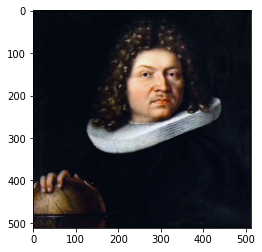

In [1452]:
# was cat, 100%
plot_laplace_prediction(model, 'img_for_task/jacob-bernoulli_eI1JNJw.jpeg')

full: cat, 100%
diag: cat, 100%


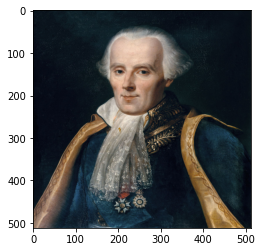

In [1453]:
# was cat, 100%
plot_laplace_prediction(model, 'img_for_task/MAT.1re.11.SYNT.laplace-retouche.jpg')

full: cat, 100%
diag: cat, 100%


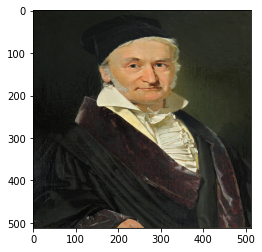

In [1454]:
# was cat, 100%
plot_laplace_prediction(model, 'img_for_task/karl-gauss.jpeg')

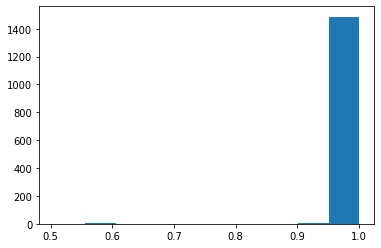

In [1455]:
# full
probs = np.array([])
for inputs, _ in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    outputs = predict(inputs)
    probs = np.append(probs, torch.max(outputs).item())

plt.hist(probs);

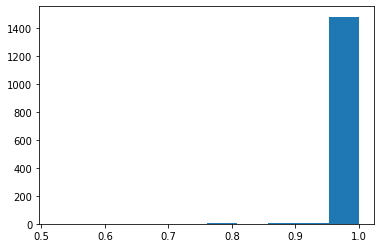

In [1456]:
# diagonal
probs = np.array([])
for inputs, _ in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    outputs = predict(inputs, kind='diag')
    probs = np.append(probs, torch.max(outputs).item())

plt.hist(probs);

Nothing really changed.

But, sample logits.

In [1474]:
W_map = model.linear.weight.clone().detach()
criterion = nn.CrossEntropyLoss(reduction='sum')

for inputs, labels in dataloaders['train']:
    inputs = inputs[0].to(device)
    labels = labels[0].to(device)
    break

optimizer.zero_grad()
outputs = model(inputs.unsqueeze(0))
loss = criterion(F.softmax(outputs, dim=1), labels.unsqueeze(0))

hess = torch.zeros((3, 3))

grad = torch.autograd.grad(outputs=loss, inputs=outputs, create_graph=True)
grad = grad[0].squeeze()

for e, g in enumerate(grad):
    model.zero_grad()
    second_order_grad = torch.autograd.grad(outputs=g, inputs=outputs, retain_graph=True)
    second_order_grad = second_order_grad[0].squeeze()
    hess[e, :] = second_order_grad

In [1483]:
@torch.no_grad()
def predict(inputs, kind='full'):
    phi = model.feature_extractor(inputs)
    m = phi @ W_map.T
    if kind == 'diag':
        sigma = torch.diag(torch.diag(hess))

    else:
        sigma = hess
    
    output_dist = MultivariateNormal(m, precision_matrix=sigma.to(device))
    # MC-integral
    n_sample = 1000
    py = torch.zeros(3).to(device)

    for _ in range(n_sample):
        out_s = output_dist.rsample().to(device)
        py += torch.softmax(out_s, 1).squeeze()

    py /= n_sample

    return py

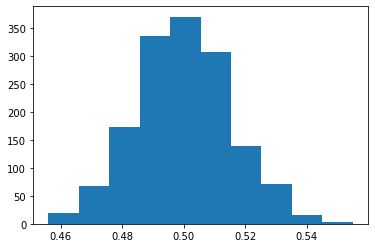

In [1484]:
probs = np.array([])
for inputs, _ in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    outputs = predict(inputs)
    probs = np.append(probs, torch.max(outputs).item())

plt.hist(probs);

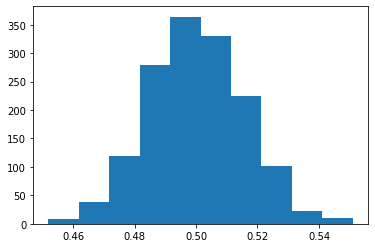

In [1485]:
probs = np.array([])
for inputs, _ in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    outputs = predict(inputs, kind='diag')
    probs = np.append(probs, torch.max(outputs).item())

plt.hist(probs);

That is from the proposed article. Makes more sense.

#### Problem 3


$$
p(W|A) = \mathcal{N}(\text{vec}(W)|\vec{0},A^{-1})
$$

$$
\mathcal{L}[q, A] = \int q(W)\log\frac{p(y,W|x,A)}{q(W)}dW = \int q(W)\log p(y|W, x)dW + \int q(W)\log \frac{p(W|A)}{q(W)}dW =  \int q(W)\log p(y|W, x)dW - D_{KL}(q || p)
$$
$$
D_{KL}(q || p) = \frac{1}{2}\left(\log \frac{|A^{-1}|}{|S|} - k + m^TAm +\mathsf{Tr}(AS)\right)
$$
where $k-$ size of $vec(W)$. Differentiate with respect to $A$ and set to 0:
$$
\nabla_A \mathcal{L}[q, A] =- \nabla_A D_{KL}(q || p) =\frac{1}{2}\left( -A^{-1} + mm^T + S \right)= 0
$$

$$
A =\left( m m^T+ S\right)^{-1}
$$

If $S-$ diagonal

$$
\alpha_i = \frac{1}{m_i^2 + s_i}
$$
$$
\mathcal{L}[m, S] = \int q(W)\log p(y|W, x)dW - \frac{1}{2}\left(\log \frac{|m m^T+ S|}{|S|} - k + m^T\left( m m^T+ S\right)^{-1}m +\mathsf{Tr}\left(\left( m m^T+ S\right)^{-1}S\right)\right)
$$

In [1387]:
from torch.nn import Parameter

class BModel(torch.nn.Module):
    def __init__(self, m, S):
        super(BModel, self).__init__()

        self.feature_extractor = models.resnet18(pretrained=True)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        for param in self.feature_extractor.fc.parameters():
            param.requires_grad = True
        
        self.prior_mu = torch.zeros((len(class_names), self.feature_extractor.fc.out_features)).to(device)
        self.prior_sigma = torch.diag(m @ m.T + S).view(len(class_names), -1).to(device)  # A^(-1)

        self.W_mu = Parameter(torch.empty((len(class_names), self.feature_extractor.fc.out_features)))
        self.W_sigma = Parameter(torch.empty((len(class_names), self.feature_extractor.fc.out_features)))
        
        self.W_mu.data = MultivariateNormal(m, S).sample((1,)).view(len(class_names), self.feature_extractor.fc.out_features)
        self.W_sigma.data = torch.diag(S).view(len(class_names), -1)

    def forward(self, x):
        x = self.feature_extractor(x)
        if self.training:
            W_eps = torch.empty(self.W_mu.size()).normal_(0, 1).to(device)
            weight = self.W_mu + self.W_sigma * W_eps
        else:
            weight = self.W_mu

        return F.linear(x, weight, None)
    
    def kl_loss(self):
        return 0.5 * (2 * torch.log(self.prior_sigma / self.W_sigma) - 1 + (self.W_sigma / self.prior_sigma).pow(2) + ((self.W_mu - self.prior_mu) / self.prior_sigma).pow(2)).sum()

In [1414]:
class ELBO(nn.Module):
    def __init__(self):
        super(ELBO, self).__init__()

    def forward(self, input, target, model):
        return F.cross_entropy(input, target) + model.kl_loss()

In [1415]:
S = torch.eye(3000)
m = torch.zeros(3000)

In [1420]:
bmodel = BModel(m, S).to(device)
criterion = ELBO()
optimizer = torch.optim.SGD(bmodel.parameters(), lr=1e-4)

In [ ]:
from tqdm.auto import tqdm

EPOCHS = 5

for epoch in range(EPOCHS):
    print(f"epoch: {epoch+1}")
    bmodel.train()
    for inputs, labels in tqdm(dataloaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = bmodel(inputs)
        loss = criterion(outputs, labels, bmodel)
        loss.backward()
        optimizer.step()

    bmodel.eval()
    running_corrects = 0
    for inputs, labels in tqdm(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            outputs = bmodel(inputs)
            _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    val_acc = running_corrects.double() / dataset_sizes['val']
    print("Validation accuracy: {0:0.0f}%".format(100*val_acc))

In [1422]:
bmodel.eval()
running_corrects = 0
for inputs, labels in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    with torch.no_grad():
        outputs = bmodel(inputs)
        _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data)
val_acc = running_corrects.double() / dataset_sizes['val']
print("Validation accuracy: {0:0.0f}%".format(100*val_acc))


Validation accuracy: 97%


cat, 100%


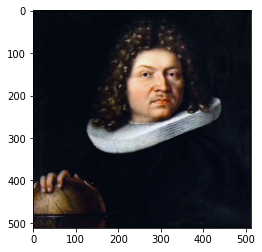

In [1423]:
plot_prediction(bmodel, 'img_for_task/jacob-bernoulli_eI1JNJw.jpeg')

cat, 100%


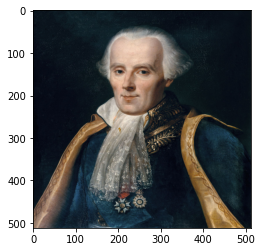

In [1424]:
plot_prediction(bmodel, 'img_for_task/MAT.1re.11.SYNT.laplace-retouche.jpg')

dog, 100%


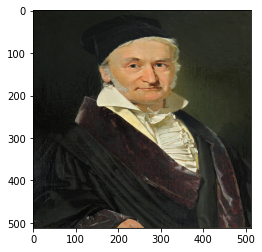

In [1425]:
plot_prediction(bmodel, 'img_for_task/karl-gauss.jpeg')

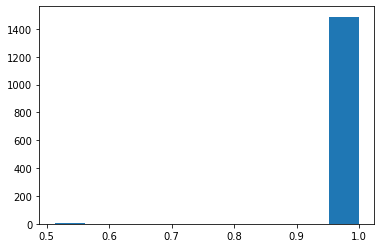

In [1426]:
import numpy as np
probs = np.array([])
for inputs, labels in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    optimizer.zero_grad()
    with torch.no_grad():
        outputs = bmodel(inputs)
        output_probs = F.softmax(outputs, dim=1)
        probs = np.append(probs, output_probs.max(1).values.cpu().numpy())


# top-class probability
plt.hist(probs);